In [7]:
from os.path import join

import os

# Tools to load, view and process images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Used to build nets or layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Pretrained models loaded in keras for transfer learning
from keras.applications import VGG16

from keras.models import Model

from keras import optimizers


import numpy as np
import warnings; warnings.simplefilter('ignore')

The data used in this example can be found on [Kaggle here](https://www.kaggle.com/c/dogs-vs-cats/data).  A very small subset is included in the folder.

# Creating a CNN

One of the biggest issues with training CNN is having enough labeled data.  One of the things that we can do is is modify the images.  We can crop zoom and rotate the data to increase our training set.  Keras has some great built in functionality to help us with this.

## Use our data


The ImageDataGenerator object can be used to modify our images as it uses them to increase our 'Training data' size by zooming, flipping and modifying the image. This also allows us to to batch the images.  This means we can take the images as in groups at a time speeding up the processing time. 

The layout of the underlying folders we use should have sample images in seperate folders representing each class we are trying to predict.

ie.
```
|_ train
        |_ Dog
        |
        |_ Cat
        
|_ test
        |_ Dog
        |
        |_ Cat

```
We then set up a generator which will pull from the given directory.



In [8]:
img_width = 250
img_height = 250
batch_size =16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# The generator object. 
train_generator = train_datagen.flow_from_directory(
    './data/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    './data/test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 24778 images belonging to 2 classes.
Found 222 images belonging to 2 classes.


## Build and train your own simple CNN

Below is the code to create a simple CNN using sequential NN with convolutional layers and pooling layers.

We have 3 convolutional and pooling layers followed by a fully connected layer

In [13]:
img_width, img_height = 250, 250

nb_train_samples = 20000
nb_validation_samples = 111
epochs = 5
batch_size = 16

### Building a model in Keras

Keras is an interface to Tensorflow or Pytorch backends which require more work to build neural net structures.  We are building a sequential model and adding layers to it.  Below we are adding three convolutional layers and 1 fully connected layers for prediction.

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)


Epoch 1/5
1250/1250 [==============================] - 345s 276ms/step - loss: 0.6549 - acc: 0.6074 - val_loss: 0.5606 - val_acc: 0.7553
Epoch 2/5
1250/1250 [==============================] - 344s 275ms/step - loss: 0.5462 - acc: 0.7272 - val_loss: 0.4614 - val_acc: 0.8125
Epoch 3/5
1250/1250 [==============================] - 344s 275ms/step - loss: 0.4971 - acc: 0.7612 - val_loss: 0.3361 - val_acc: 0.8723
Epoch 4/5
1250/1250 [==============================] - 343s 274ms/step - loss: 0.4693 - acc: 0.7780 - val_loss: 0.3637 - val_acc: 0.8333
Epoch 5/5
1250/1250 [==============================] - 343s 274ms/step - loss: 0.4422 - acc: 0.7982 - val_loss: 0.4883 - val_acc: 0.7500


The print out that you see above is compiled as the model is trained (as the weights of the NN are modified by backpropagation).  The second score val_acc tells us how well the model is doing against the data we held out in the test set of pictures.

Note this took about 25 minutes to run

# Transfer Learning

Instead of having to start the process of building a NN form scratch and training it we can make use of other people's work.

It is expensive to train all the layers of a CNN when most of the layers are trained to learn feature and shape detection.  It is possable to use the trained layers of a complex CNN and just train the final `classification layer` (fully connected layer).  This is referred to as transfer learning.


## VGG16

There are many different CNN models out there that can be used to speed up training and prediction.  Below we are going to use one example the VGG16 model.

![VGG16](./img/vgg16.png)




Import the trained model (include_top refers to including the fully connected layers)

In [18]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(250,250,3))

58892288/58889256 [==============================] - 1s 0us/step


The below functions can be used to modify the imported model by adding a fully connected layer to the model and set all CNN layers fixed so we are only updating the new fully connected layer.

In [19]:
def add_new_last_layer(base_model, nb_classes=2):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the models last layer
    x = base_model.output
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [20]:
# This will freeze the weights on all the layers except for our new dense layer
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam',    
                loss='binary_crossentropy', 
                metrics=['accuracy'])


In [21]:
train_model = add_new_last_layer(base_model)
setup_to_transfer_learn(train_model,base_model)

In [22]:
nb_epoch = 1

train_model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/1
1250/1250 [==============================] - 348s 278ms/step - loss: 0.2795 - acc: 0.8772 - val_loss: 0.1969 - val_acc: 0.9375


In less than 5 minutes I have created a CNN that is 95% accurate by using transfer learning.  This is a better model then the one made above with far less training because we used the pretrained convolutional layers

Lets test it on an image we can look at we can use the Keras load_img function to load an image of the correct size and get a prediction on it by running it through our model

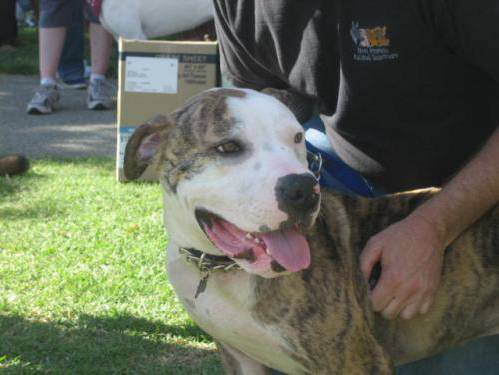

In [30]:
load_img('./data/test/Dog/dog.49.jpg')

In [47]:
#Load the image
img = load_img('./data/test/Dog/dog.4944.jpg',target_size=(250,250) )
# Convert it to a array so it will work in Keras
img = img_to_array(img)
# We need to add a dimension to it as our model expects 16 images at a time so we need to add
# that only one image is being passed in
img = img.reshape((1,) + img.shape)


pred = train_model.predict(img)
pred[0][0]

1.0

Here the value printed is a probability of the image having a dog in it so 1.0 is very likely a dog and 0.0 is very likely a cat

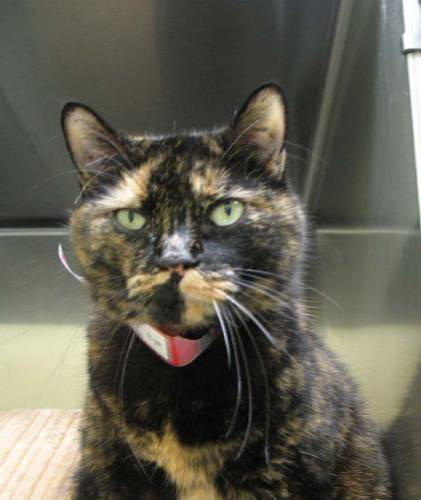

In [44]:
load_img('./data/test/Cat/cat.495.jpg' )

In [46]:
img = load_img('./data/test/Cat/cat.495.jpg',target_size=(250,250) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
pred = train_model.predict(img)
pred[0][0]

0.0

# The power of pretrained CNNs

Here we will use another trained CNN ResNet unmodified

In [56]:
img_paths = ['./data/test/Dog/dog.4945.jpg', './data/test/Cat/cat.4945.jpg']

In [49]:
import numpy as np
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.python.keras.applications import ResNet50


image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

In [52]:


my_model = ResNet50()


In [57]:
test_data = read_and_prep_images(img_paths)
my_preds = my_model.predict(test_data)

In [58]:
label = decode_predictions(my_preds)

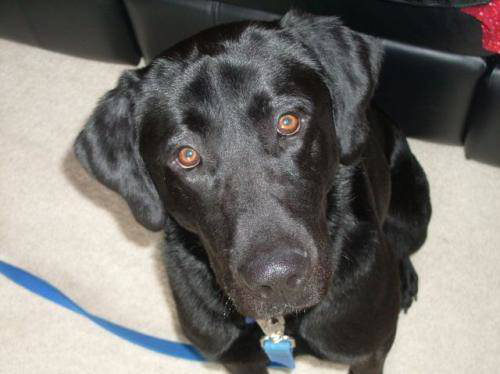

[('n02099712', 'Labrador_retriever', 0.87272054),
 ('n02109047', 'Great_Dane', 0.080982424),
 ('n02100236', 'German_short-haired_pointer', 0.017452221),
 ('n02099267', 'flat-coated_retriever', 0.0123293465),
 ('n02089078', 'black-and-tan_coonhound', 0.0045382828)]

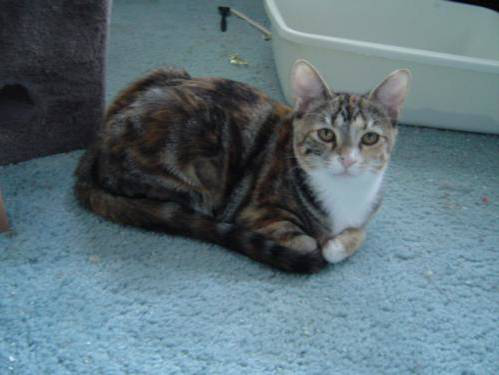

[('n02123045', 'tabby', 0.44027808),
 ('n02123159', 'tiger_cat', 0.17104132),
 ('n02124075', 'Egyptian_cat', 0.16652256),
 ('n04265275', 'space_heater', 0.01667544),
 ('n02113186', 'Cardigan', 0.0103072105)]

In [59]:
for link,i in zip(img_paths,label):
    print()
    display(load_img(link))
    display(i)